In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib
from pprint import pprint

In [2]:
patients = pd.read_csv('./Robo/Data/patient.csv',index_col='PatientGuid').sort_index()
diagnosis = pd.read_csv('./Robo/Data/diagnosis.csv',index_col='PatientGuid').sort_index()
physicians = pd.read_csv('./Robo/Data/physician_specialty.csv',index_col='PatientGuid').sort_index()
transcripts = pd.read_csv('./Robo/Data/transcript.csv',index_col='PatientGuid').sort_index()
#medications = pd.read_csv('./Robo/Data/medication.csv',index_col='PatientGuid').sort_index()
medication_new = pd.read_csv('./Robo/Data/medic_new.csv',index_col='PatientGuid').sort_index()
#medications.columns = map(lambda x:'med_'+x,medications.columns)
#data = pd.concat([diagnosis,physicians,transcripts,medications,patients], axis=1)
data = pd.concat([diagnosis,physicians,transcripts,medication_new,patients], axis=1)
data.fillna(0,inplace=True)

#create artificial IDs, to keep track of training and validation sets later

data['ID'] = range(data.shape[0])

c:\users\rupadhyay\python 3.6\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9948 entries, 00023761-9D8D-445B-874C-2424CC7CF620 to FFF5C634-1CF7-40D5-BDF1-4FA2D62D9C63
Columns: 2678 entries, Icd9_001-139 to ID
dtypes: float64(2650), int32(1), int64(27)
memory usage: 203.3+ MB


In [5]:
target = 'DMIndicator'
categorical = ['Gender','State']
categorical += [x for x in data.columns if 'Icd' in x]
categorical += [x for x in data.columns if 'PhySp' in x]
numerical = data[[x for x in data.columns if (x not in categorical)]].columns.tolist()
categorical += ['ID']


### Functions for Visualization

In [6]:


def box_numerical(df,col,target='DMIndicator',ylim=[0,25]):
    
    plt.figure(figsize=(5,3))
    plt.boxplot([df[col][df[target] == 0],df[col][df[target] == 1]])
    plt.xticks([1,2],[0,1])
    plt.ylim(ylim)
    plt.ylabel(col)
    print (col,stats.ttest_ind(df[col][df[target] == 1],df[col][df[target] == 0]))

In [7]:
def hist_numerical(df,col):
    x = data[col]
    plt.hist([x[data['DMIndicator'] == 1],x[data['DMIndicator'] == 0]],bins=20)
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.legend([1,0],title='DMIndicator')
    plt.show()

In [8]:
numerical

['DiagnosisCount',
 'VisitCount',
 'DiagnosisFreq',
 'AcuteCount',
 'AcuteFreq',
 'Height_Max',
 'Weight_Max',
 'BMI_Max',
 'SystolicBP_Max',
 'DiastolicBP_Max',
 'RespiratoryRate_Max',
 'Temperature_Max',
 'Height_Min',
 'Weight_Min',
 'BMI_Min',
 'SystolicBP_Min',
 'DiastolicBP_Min',
 'RespiratoryRate_Min',
 'Temperature_Min',
 'Height_Std',
 'Weight_Std',
 'BMI_Std',
 'SystolicBP_Std',
 'DiastolicBP_Std',
 'RespiratoryRate_Std',
 'Temperature_Std',
 'Height_Mean',
 'Weight_Mean',
 'BMI_Mean',
 'SystolicBP_Mean',
 'DiastolicBP_Mean',
 'RespiratoryRate_Mean',
 'Temperature_Mean',
 'BMI_Change',
 'DiastolicBP_Change',
 'Height_Change',
 'RespiratoryRate_Change',
 'SystolicBP_Change',
 'Temperature_Change',
 'Weight_Change',
 'MedicationName_A/B Otic (antipyrine-benzocaine otic) otic solution',
 'MedicationName_ALPRAZolam ER (ALPRAZolam) oral tablet, extended release',
 'MedicationName_AMILoride HCl-Hydrochlorothiazide (aMILoride-hydrochlorothiazide) oral tablet',
 'MedicationName_AMILo

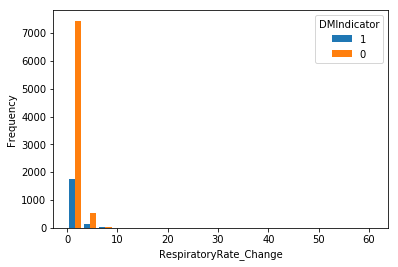

In [32]:
hist_numerical(data,'RespiratoryRate_Change')


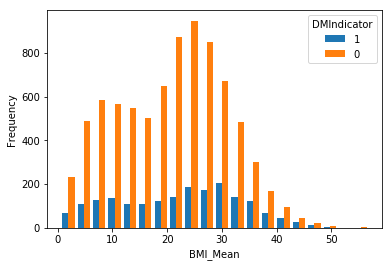

In [33]:
hist_numerical(data,'BMI_Mean')

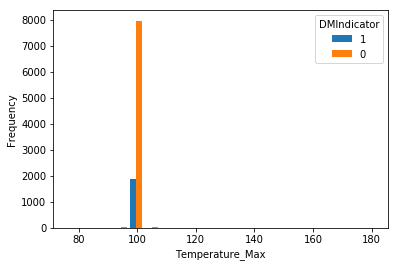

In [34]:
hist_numerical(data,'Temperature_Max')

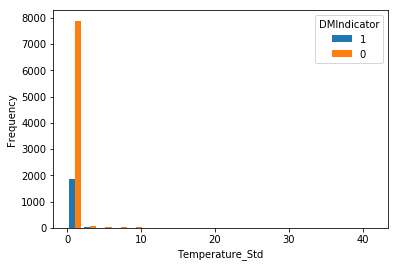

In [35]:
hist_numerical(data,'Temperature_Std')

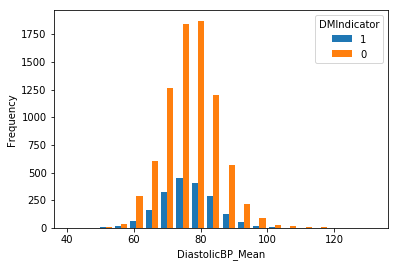

In [36]:
hist_numerical(data,'DiastolicBP_Mean')

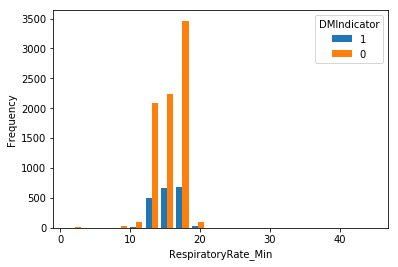

In [37]:
hist_numerical(data,'RespiratoryRate_Min')

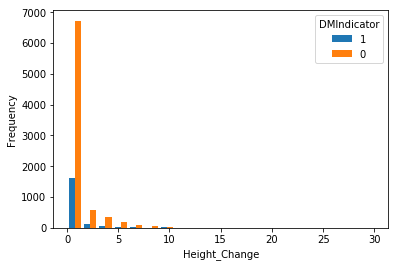

In [38]:
hist_numerical(data,'Height_Change')

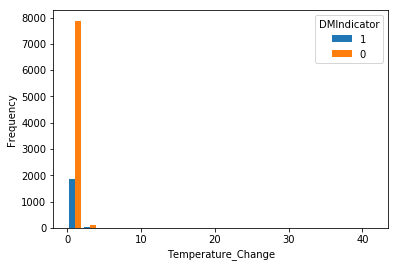

In [39]:
hist_numerical(data,'Temperature_Change')

In [10]:
#after having a look at each variable, following are found to be non important
non_important = ['Temperature_Max',
                'Temperature_Std','Height_Change','RespiratoryRate_Change',
                 'Temperature_Change']

In [167]:
numerical

['DiagnosisCount',
 'VisitCount',
 'DiagnosisFreq',
 'AcuteCount',
 'AcuteFreq',
 'Height_Max',
 'Weight_Max',
 'BMI_Max',
 'SystolicBP_Max',
 'DiastolicBP_Max',
 'RespiratoryRate_Max',
 'Temperature_Max',
 'Height_Min',
 'Weight_Min',
 'BMI_Min',
 'SystolicBP_Min',
 'DiastolicBP_Min',
 'RespiratoryRate_Min',
 'Temperature_Min',
 'Height_Std',
 'Weight_Std',
 'BMI_Std',
 'SystolicBP_Std',
 'DiastolicBP_Std',
 'RespiratoryRate_Std',
 'Temperature_Std',
 'Height_Mean',
 'Weight_Mean',
 'BMI_Mean',
 'SystolicBP_Mean',
 'DiastolicBP_Mean',
 'RespiratoryRate_Mean',
 'Temperature_Mean',
 'BMI_Change',
 'DiastolicBP_Change',
 'Height_Change',
 'RespiratoryRate_Change',
 'SystolicBP_Change',
 'Temperature_Change',
 'Weight_Change',
 'MedicationName_A/B Otic (antipyrine-benzocaine otic) otic solution',
 'MedicationName_ALPRAZolam ER (ALPRAZolam) oral tablet, extended release',
 'MedicationName_AMILoride HCl-Hydrochlorothiazide (aMILoride-hydrochlorothiazide) oral tablet',
 'MedicationName_AMILo

### Feature selection

In [12]:
#import scikit learn libraries
from sklearn import cross_validation, metrics #model optimization and valuation tool
from sklearn.grid_search import GridSearchCV #performing grid search
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier


c:\users\rupadhyay\python 3.6\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
c:\users\rupadhyay\python 3.6\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [13]:
#create functions to tune parameters

def modelfit(alg,dtrain,predictors,target,scoring_method,performCV=True,cv_folds=5):
    #Train the algorithm on data, This functions train the model given as 'alg' by performing cross-validation
    alg.fit(dtrain[predictors],dtrain[target])
    
    #predict on training set
    dtrain_predictions = alg.predict(dtrain[predictors])
    if scoring_method == 'roc_auc':
        dtrain_predprob = alg.predict_proba(dtrain[predictors]) [:,1]
    
    #Perform cross validation
    if performCV:
        cv_score = cross_validation.cross_val_score(alg,dtrain[predictors],dtrain[target],cv=cv_folds,scoring=scoring_method)
        #print model report
        print ("\n Model Report: ")
        if (scoring_method == 'roc_auc'):
            print("Accuracy : ",metrics.accuracy_score(dtrain[target].values,dtrain_predictions))
            print("AUC score (Train):", metrics.roc_auc_score(dtrain[target],dtrain_predprob))  
        
        if (scoring_method == 'mean_squared_error'):
            print("Accuracy : ",metrics.mean_squared_error(dtrain[target].values,dtrain_predictions))
    
    if performCV:
        print("CV Score - Mean : %.7g | Std : %.7g | Min : %.7g | Max : %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
           
    return alg

def optimize_num_trees(alg,param_test,scoring_method,train,predictors,target):
    #This functions is used to tune paremeters of a predictive algorithm
    gsearch = GridSearchCV(estimator=alg, param_grid = param_test, scoring = scoring_method, n_jobs=2,iid=False, cv=5)
    gsearch.fit(train[predictors],train[target])
    return gsearch
    

In [14]:
#Create different set of labels 

labels1 = list(filter(lambda x: not x.startswith('Med'),list(set(numerical).difference(set(non_important)))))  #Numerical

labels1.pop(labels1.index('DMIndicator'))
labels2 = categorical[:]
labels3 = ['ID','Icd9_390-459', 'State', 'Icd9_240-279', 'PhySp_Internal_Medicine', 'PhySp_Family_Practice', 'PhySp_General_Practice', 'Icd9_780-799', 'PhySp_Unknown', 'Icd9_710-739', 'Icd9_E-V', 'Gender', 'PhySp_Geriatric_Medicine', 'Icd9_290-319', 'PhySp_Podiatry', 'PhySp_Cardiovascular_Disease', 'PhySp_Pulmonary_Disease', 'Icd9_580-629', 'PhySp_Endocrinology__Diabetes__Metabolism', 'PhySp_Adolescent_Medicine', 'PhySp_Nephrology', 'Icd9_280-289', 'Icd9_460-519', 'Icd9_320-359', 'Icd9_680-709', 'Icd9_520-579']

labels4 = list(filter(lambda x: x.startswith('Med'),data.columns))+['ID']
#gbm_med_feature_list = gbm_med_feature_list+['ID']

#split data into training and validation sets
_Xtrain,_Xvalid,_Ytrain,_Yvalid = train_test_split(data[labels4],data[target],test_size=1/4.,random_state=123)
#_Xtrain,_Xvalid,_Ytrain,_Yvalid = train_test_split(data[gbm_med_feature_list],data[target],test_size=1/4.,random_state=123)
_train_ids = _Xtrain.ID.tolist()
_valid_ids = _Xvalid.ID.tolist()

In [15]:
labels1.pop(labels1.index('ID'))
labels2.pop(labels2.index('ID'))
labels3.pop(labels3.index('ID'))
labels4.pop(labels4.index('ID'))

'ID'

#### Optimizing parameters to tune the Model

In [16]:
gbm1 = GradientBoostingClassifier(
    learning_rate = 0.1,
    min_samples_split = 2,
    max_depth = 2,
    max_features='auto',
    subsample=0.8,
    random_state=10
)
train = _Xtrain.copy()

train['DMIndicator'] = _Ytrain
param_test = {'n_estimators': np.arange(10,151,20)} #labels2->range(250,501,20), labels1->range(10,151,20)
predictors = labels4


# optimize number of trees
gs_cls = optimize_num_trees(gbm1,param_test,'roc_auc',train,predictors,target)
print ("Best Parameters:\n\t",gs_cls.best_params_)
print ("Best Score:\n\t",gs_cls.best_score_)
print ("Grid Scores:")
pprint(gs_cls.grid_scores_)


# cross validate the best model with optimized number of estimators
alg = modelfit(gs_cls.best_estimator_,train,predictors,target,'roc_auc')

# testing on a different set
ypred = gs_cls.best_estimator_.predict(_Xvalid[predictors])
print ("ROC AUC:", metrics.roc_auc_score(ypred,_Yvalid))

#Best parameter for labels4 is n_estimators = 150

Best Parameters:
	 {'n_estimators': 150}
Best Score:
	 0.6823922983815904
Grid Scores:
[mean: 0.62673, std: 0.01034, params: {'n_estimators': 10},
 mean: 0.65172, std: 0.01171, params: {'n_estimators': 30},
 mean: 0.66219, std: 0.01230, params: {'n_estimators': 50},
 mean: 0.66563, std: 0.01091, params: {'n_estimators': 70},
 mean: 0.67194, std: 0.01461, params: {'n_estimators': 90},
 mean: 0.67548, std: 0.01566, params: {'n_estimators': 110},
 mean: 0.67748, std: 0.01514, params: {'n_estimators': 130},
 mean: 0.68239, std: 0.01646, params: {'n_estimators': 150}]

 Model Report: 
Accuracy :  0.826028682482241
AUC score (Train): 0.7418673138575368
CV Score - Mean : 0.6823923 | Std : 0.01645981 | Min : 0.6537964 | Max : 0.7008976
ROC AUC: 0.7381904547332057


#### Use optimized parameters to make final predictions

In [28]:
# prep training and validation
train = data[data.ID.isin(_train_ids)]
valid = data[data.ID.isin(_valid_ids)]

# set optimized parameters
gbm_num = GradientBoostingClassifier(n_estimators = 90,learning_rate = 0.1,
                                     min_samples_split=2,max_depth=2,max_features='auto',
                                     subsample=0.8,random_state = 10)
gbm_cat = GradientBoostingClassifier(n_estimators = 350,learning_rate = 0.1,
                                     min_samples_split=2,max_depth=2,max_features='auto',
                                     subsample=0.8,random_state = 10)
gbm_med = GradientBoostingClassifier(n_estimators= 150, learning_rate=0.1,
                                     min_samples_split=2, max_depth=2, max_features='auto',
                                     subsample=0.8,random_state = 10)

#train the model
print ("Training models")
print ("---------------")
print ("-- Numerical variables --")
alg_num = modelfit(gbm_num,train,labels1,target,'roc_auc')
print ("-- Categorical variables --")
#alg_cat = modelfit(gbm_cat,train,labels3,target,'roc_auc')
alg_cat = modelfit(gbm_cat,train,labels2,target,'roc_auc')
#alg_cat = modelfit(gbm_cat,train,gbm_cat_feature_list,target,'roc_auc')
print ("-- Medication Names --")
alg_med = modelfit(gbm_med,train,labels4,target,'roc_auc')
#alg_med = modelfit(gbm_med,train,gbm_med_feature_list,target,'roc_auc')

Training models
---------------
-- Numerical variables --

 Model Report: 
Accuracy :  0.8272349550998526
AUC score (Train): 0.8172019645842516
CV Score - Mean : 0.7781192 | Std : 0.01180775 | Min : 0.7596628 | Max : 0.79189
-- Categorical variables --

 Model Report: 
Accuracy :  0.8356788634231336
AUC score (Train): 0.8308226731210163
CV Score - Mean : 0.7719388 | Std : 0.008547685 | Min : 0.7622781 | Max : 0.7873358
-- Medication Names --

 Model Report: 
Accuracy :  0.8258946521913952
AUC score (Train): 0.7379415878587251
CV Score - Mean : 0.6817125 | Std : 0.01610169 | Min : 0.6617896 | Max : 0.7020862


In [21]:
gbm_imp_features = gbm_med.feature_importances_.argsort()[::-1][:100]
gbm_med_feature_list = [labels4[i] for i in gbm_imp_features]
gbm_med_feature_list


['MedicationName_Lisinopril oral tablet',
 'MedicationName_Zocor (simvastatin) oral tablet',
 'MedicationName_Simvastatin oral tablet',
 'MedicationName_Lasix (furosemide) oral tablet',
 'MedicationName_Cozaar (losartan) oral tablet',
 'MedicationName_Lipitor (atorvastatin) oral tablet',
 'MedicationName_Coreg (carvedilol) oral tablet',
 'MedicationName_TriCor (fenofibrate) oral tablet',
 'MedicationName_Hyzaar (hydrochlorothiazide-losartan) oral tablet',
 'MedicationName_Lovastatin oral tablet',
 'MedicationName_Cheratussin AC (codeine-guaiFENesin) oral syrup',
 'MedicationName_Mevacor (lovastatin) oral tablet',
 'MedicationName_Furosemide oral tablet',
 'MedicationName_Crestor (rosuvastatin) oral tablet',
 'MedicationName_Pravachol (pravastatin) oral tablet',
 'MedicationName_Enalapril Maleate (enalapril) oral tablet',
 'MedicationName_Ecotrin Adult Low Strength (aspirin) oral enteric coated tablet',
 'MedicationName_TriCor (fenofibrate) oral capsule',
 'MedicationName_Acarbose oral 

In [132]:
gbm_cat_features = gbm_cat.feature_importances_.argsort()[::-1][:40]
gbm_cat_feature_list = [labels2[i] for i in gbm_cat_features]
gbm_cat_feature_list

['Icd9_390-459',
 'State',
 'PhySp_Internal_Medicine',
 'Icd9_240-279',
 'PhySp_General_Practice',
 'PhySp_Family_Practice',
 'PhySp_Unknown',
 'Icd9_290-319',
 'PhySp_Geriatric_Medicine',
 'Icd9_710-739',
 'Icd9_780-799',
 'PhySp_Podiatry',
 'Icd9_E-V',
 'PhySp_Endocrinology__Diabetes__Metabolism',
 'PhySp_Cardiovascular_Disease',
 'PhySp_Nephrology',
 'Gender',
 'Icd9_580-629',
 'Icd9_680-709',
 'Icd9_320-359',
 'Icd9_460-519',
 'Icd9_280-289',
 'PhySp_Adolescent_Medicine',
 'PhySp_Pulmonary_Disease',
 'PhySp_Diagnostic_Radiology',
 'PhySp_Obstetrics_Gynecology',
 'Icd9_520-579',
 'PhySp_Dermatology',
 'PhySp_Critical_Care_Medicine',
 'PhySp_Hematology_Oncology',
 'PhySp_Physical_Medecine',
 'Icd9_Unknown',
 'PhySp_Surgery',
 'Icd9_001-139',
 'Icd9_140-239',
 'PhySp_Neurology',
 'Icd9_360-389',
 'PhySp_Nutrition',
 'PhySp_Infectious_Disease',
 'PhySp_Orthopaedic_Trauma']

In [30]:
#Make Predictions
ypred_num = alg_num.predict(valid[labels1])
#ypred_cat = alg_cat.predict(valid[labels3])
ypred_cat = alg_cat.predict(valid[labels2])
ypred_med = alg_med.predict(valid[labels4])

#ypred_med = alg_med.predict(valid[gbm_med_feature_list])

ypredprob_num = alg_num.predict_proba(valid[labels1])[:,1]
#ypredprob_cat = alg_cat.predict_proba(valid[labels3])[:,1]
ypredprob_cat = alg_cat.predict_proba(valid[labels2])[:,1]
ypredprob_med = alg_med.predict_proba(valid[labels4])[:,1]

#ypredprob_med = alg_med.predict_proba(valid[gbm_med_feature_list])[:,1]

#create an ensemble of models based of categorical and numerical variables
#ypred_combo = ((0.5*ypredprob_num + 0.0*ypredprob_cat +0.5*ypredprob_med)>0.5)*1

ypred_combo = ((0.4*ypredprob_num + 0.2*ypredprob_cat +0.4*ypredprob_med)>0.5)*1

print ("====== Model validation ======")
print ("Summary results")
print ("ROC AUC - numerical variables model:", round(metrics.roc_auc_score(ypred_num,valid[target]),3))
print ("ROC AUC - categorical variables model:", round(metrics.roc_auc_score(ypred_cat,valid[target]),3))
print ("ROC AUC - medication names model:", round(metrics.roc_auc_score(ypred_med,valid[target]),3))
print ("ROC AUC - ensemble model:", round(metrics.roc_auc_score(ypred_combo,valid[target]),3))



====== Model validation ======
Summary results
ROC AUC - numerical variables model: 0.71
ROC AUC - categorical variables model: 0.695
ROC AUC - medication names model: 0.749
ROC AUC - ensemble model: 0.793


### Optimize weights for the final ensemble model

Use a Modified Gradient Descent algorithm to find the best weights to allocate to each of the three models

In [31]:
def loss(w,yps):
    yp_combo = ((w[0]*yps[0]+w[1]*yps[1]+w[2]*yps[2])>0.5)*1
    return 1-metrics.roc_auc_score(yp_combo,valid[target])


def dloss(w,yps,learning_rate = 0.0001):
    dw = [metrics.roc_auc_score(yps[0]>0.5,valid[target]),
          metrics.roc_auc_score(yps[0]>0.5,valid[target]),
          metrics.roc_auc_score(yps[0]>0.5,valid[target])]
    w = [w[i] - (learning_rate*dw[i]) for i in range(len(w))]
    try:
        error = loss(w,yps)
        return [w,error]
    except:
        pass
        return [w,1000]
    

def optimize(w,yps,learning_rate = 0.0001,n_iters = 1000,plot_error=False):
    r = [w,loss(w,yps)]
    for i in range(n_iters):
        r.append(dloss(r[-1][0],yps,learning_rate=learning_rate))
    if plot_error:
        plt.plot(map(lambda x:x[1],r))
        plt.show()
    return r[-1][0]
#dloss([.5,.2,.3],[ypredprob_num,ypredprob_cat,ypredprob_med], learning_rate=0.01)
#optimize([0.5,.3,.2],[ypredprob_num,ypredprob_cat,ypredprob_med],learning_rate=0.01,plot_error=True)
w0 = [.5,.2,.3]
yps0 = [ypredprob_num,ypredprob_cat,ypredprob_med]
ers = []
ws = []
for i in range(1000):
    w0,er =  dloss(w0,yps0, learning_rate= 0.001)
    ws.append(w0)
    ers.append(er)
#plt.plot(er)
#plt.show()
n = ers.index(min(ers))
w_opt = list(map(lambda x:round(x,3),ws[n]))
print ("1 - AUC:",ers[n],"\tweights:",w_opt)

print ("====== Optimized ensemble model ======")
ypred_combo = ((w_opt[0]*ypredprob_num + w_opt[1]*ypredprob_cat + w_opt[2]*ypredprob_med)>0.5)*1
print ("ROC AUC - ensemble model:", round(metrics.roc_auc_score(ypred_combo,valid[target]),3))

1 - AUC: 0.12495954692556632 	weights: [0.482, 0.182, 0.282]
====== Optimized ensemble model ======
ROC AUC - ensemble model: 0.875
